## 績效算法

In [5]:
import numpy as np

def reliability_score(y, lower, upper):
    inside = (y >= lower) & (y <= upper)
    return np.mean(inside)


def dr_metric(rs, alpha):
    return rs - (1 - alpha)


def pi_width(lower, upper):
    return upper - lower


def aw_metric(lower, upper):
    return np.mean(pi_width(lower, upper))


def apis_metric(y, lower, upper, alpha):
    w = pi_width(lower, upper)
    # 局部偏離量
    dev = np.zeros_like(y, dtype=float)
    below = y < lower
    above = y > upper
    dev[below] = lower[below] - y[below]
    dev[above] = y[above] - upper[above]

    penalty = (2.0 / alpha) * dev

    return np.mean(w + penalty)


def pinball_loss(y, pred, q):
    r = y - pred
    return np.mean(np.where(r > 0, q * r, (q - 1) * r))

## data & parameters

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

path = r"C:\Users\坤達\Downloads\energy_efficiency_data.csv"
df = pd.read_csv(path)

feature_cols = df.columns[:8].tolist()
label_col = "Heating_Load"

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df[label_col],
    test_size=0.2, random_state=42
)

train_df = pd.concat([X_train, y_train.rename(label_col)], axis=1)
train_dataset = train_df.values.tolist()
feature_names = feature_cols.copy()

max_depth = 5
min_size = 1

## QRT with r2

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score


def r2_split(groups, quantile):
    all_labels = []
    all_preds = []
    for group in groups:
        if not group:
            continue
        group_labels = [float(row[-1]) for row in group]
        group_pred = np.quantile(group_labels, quantile)
        all_labels.extend(group_labels)
        all_preds.extend([group_pred] * len(group_labels))

    if len(all_labels) == 0:
        return -float('inf')

    return r2_score(all_labels, all_preds)


#對每個切分點依據分割後各群組R²值來評估，
#選擇使R²值最大的切分點與對應的子群。
def split_numeric_r2(feature_idx, dataset, quantile):
    vals = sorted({float(row[feature_idx]) for row in dataset})

    if len(vals) < 2:
        return None, None

    best_thr, best_grps, best_r2 = None, None, -float('inf')

    # 只在相鄰實數值之間嘗試 threshold
    for v1, v2 in zip(vals[:-1], vals[1:]):
        thr = (v1 + v2) / 2.0

        left = [r for r in dataset if float(r[feature_idx]) < thr]
        right = [r for r in dataset if float(r[feature_idx]) >= thr]
        # 跳過空組
        if not left or not right:
            continue

        cur_r2 = r2_split([left, right], quantile)
        if cur_r2 > best_r2:
            best_r2, best_thr, best_grps = cur_r2, thr, {'<': left, '>=': right}

    return best_thr, best_grps


#根據R²值選出最佳切分特徵與切分點。
def get_best_split_r2(dataset, quantile):
    best_r2 = -float('inf')
    best_feat = None
    best_groups = None
    best_threshold = None

    n_feat = len(dataset[0]) - 1
    for f in range(n_feat):
        threshold, groups = split_numeric_r2(f, dataset, quantile)
        if groups is None:
            continue
        current_r2 = r2_split(list(groups.values()), quantile)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_feat = f
            best_groups = groups
            best_threshold = threshold
    return {
        'feature': best_feat,
        'groups': best_groups,
        'threshold': best_threshold
    }


def terminal_r2(group, quantile):
    labels = [float(row[-1]) for row in group]
    return np.quantile(labels, quantile)


def build_tree_r2(dataset, feature_names, quantile, max_depth, min_size):
    root_node = {
        'dataset': dataset,
        'node_id': 0,
        'parent_id': None,
        'depth': 1,
        'feature_from_parent': None,
        'condition_from_parent': None,
        'numeric_threshold': None,
    }

    queue = deque([root_node])
    node_counter = 1
    tree_data = []

    while queue:
        node = queue.popleft()
        data_here = node['dataset']
        depth = node['depth']

        best = get_best_split_r2(data_here, quantile)
        feat_idx = best['feature']
        groups = best['groups']
        threshold = best['threshold']

        if feat_idx is None or depth >= max_depth:
            pred = terminal_r2(data_here, quantile)
            tree_data.append([
                node['node_id'],
                node['parent_id'],
                node['feature_from_parent'],
                node['condition_from_parent'],
                node['numeric_threshold'],
                pred
            ])
            continue

        tree_data.append([
            node['node_id'],
            node['parent_id'],
            node['feature_from_parent'],
            node['condition_from_parent'],
            node['numeric_threshold'],
            None
        ])

        feat_name = feature_names[feat_idx]

        for cond, grp in groups.items():
            if len(grp) <= min_size:
                pred2 = terminal_r2(grp, quantile)
                tree_data.append([
                    node_counter,
                    node['node_id'],
                    feat_name,
                    cond,
                    threshold,
                    pred2
                ])
                node_counter += 1
            else:
                child_node = {
                    'dataset': grp,
                    'node_id': node_counter,
                    'parent_id': node['node_id'],
                    'depth': depth + 1,
                    'feature_from_parent': feat_name,
                    'condition_from_parent': cond,
                    'numeric_threshold': threshold,
                }
                node_counter += 1
                queue.append(child_node)

    return tree_data


def build_tree_dict(tree_list):
    tree_nodes = {}
    children_map = {}
    for row in tree_list:
        node_id, parent_id, feature_name, condition, numeric_threshold, pred = row
        node_dict = {
            'node_id': node_id,
            'parent_id': parent_id,
            'feature_name': feature_name,
            'condition': condition,
            'numeric_threshold': numeric_threshold,
            'prediction': pred
        }
        tree_nodes[node_id] = node_dict
        if parent_id is not None:
            children_map.setdefault(parent_id, []).append(node_dict)
    return tree_nodes, children_map


def predict_sample(sample, tree_nodes, children_map):
    current_node = tree_nodes[0]
    while True:
        node_id = current_node['node_id']
        children = children_map.get(node_id, [])
        if not children:
            return current_node['prediction']

        splitting_feature = children[0]['feature_name']
        sample_value = sample[splitting_feature]
        found_child = None

        try:
            sample_value_numeric = float(sample_value)
        except:
            sample_value_numeric = None
        for child in children:
            if child['condition'] == '<':
                if sample_value_numeric is not None and sample_value_numeric < child['numeric_threshold']:
                    found_child = child
                    break
            elif child['condition'] == '>=':
                if sample_value_numeric is not None and sample_value_numeric >= child['numeric_threshold']:
                    found_child = child
                    break

        if found_child is None:
            candidate_preds = [child['prediction'] for child in children if child['prediction'] is not None]
            if candidate_preds:
                return np.mean(candidate_preds)
            else:
                return None

        current_node = found_child
        if current_node['prediction'] is not None:
            return current_node['prediction']


def predict_dataset(X_df, tree_nodes, children_map):
    preds = []
    for _, row in X_df.iterrows():
        sample = row.to_dict()
        pred = predict_sample(sample, tree_nodes, children_map)
        preds.append(pred)
    return preds


#區間預測
def predict_qrt_r2_interval(lower_q, upper_q, max_depth, min_size):
    lower_tree = build_tree_r2(train_dataset, feature_names, quantile=lower_q,
                               max_depth=max_depth, min_size=min_size)
    upper_tree = build_tree_r2(train_dataset, feature_names, quantile=upper_q,
                               max_depth=max_depth, min_size=min_size)

    lt_nodes, lt_map = build_tree_dict(lower_tree)
    ut_nodes, ut_map = build_tree_dict(upper_tree)

    lower_preds = np.array(predict_dataset(pd.DataFrame(X_test, columns=feature_names),
                                           lt_nodes, lt_map), dtype=float)
    upper_preds = np.array(predict_dataset(pd.DataFrame(X_test, columns=feature_names),
                                           ut_nodes, ut_map), dtype=float)
    return y_test, lower_preds, upper_preds


#單點預測
def predict_qrt_r2_single(QUANTILE, max_depth, min_size):
    tree_list = build_tree_r2(train_dataset, feature_names, quantile=QUANTILE, max_depth=max_depth, min_size=min_size)
    tree_nodes, children_map = build_tree_dict(tree_list)

    preds = np.array(predict_dataset(X_test, tree_nodes, children_map), dtype=float)
    return y_test, preds


# 想大致看輸出是甚麼的話可以看這部分

In [18]:
tree_list = build_tree_r2(train_dataset, feature_names, quantile=0.5, max_depth=3, min_size=1)

columns = ["Node ID", "Parent ID", "Feature Name", "Condition", "Numeric Threshold", "Prediction"]
tree_df = pd.DataFrame(tree_list, columns=columns) \
    .sort_values("Node ID") \
    .reset_index(drop=True)

print("result:")
print(tree_df)

result:
   Node ID  Parent ID          Feature Name Condition  Numeric Threshold  \
0        0        NaN                  None      None                NaN   
1        1        0.0  Relative_Compactness         <              0.750   
2        2        0.0  Relative_Compactness        >=              0.750   
3        3        1.0          Glazing_Area         <              0.175   
4        4        1.0          Glazing_Area        >=              0.175   
5        5        2.0  Relative_Compactness         <              0.805   
6        6        2.0  Relative_Compactness        >=              0.805   

   Prediction  
0         NaN  
1         NaN  
2         NaN  
3      11.215  
4      14.460  
5      37.795  
6      28.660  


## QRT with loss

In [4]:

import pandas as pd
from collections import deque


#用loss來評估切分品質
def quantile_loss(groups, quantile):
    total_loss = 0.0
    for group in groups:
        if not group:
            continue
        labels = np.array([float(row[-1]) for row in group])
        q_val = np.quantile(labels, quantile)
        r = labels - q_val
        total_loss += np.sum(
            np.where(r <= 0,
                     quantile * np.abs(r),
                     (1 - quantile) * np.abs(r))
        )

    return total_loss


#對每個切分點依據分割後各群組loss值來評估，
#選擇使loss值最小的切分點與對應的子群。
def split_numeric_loss(feature_idx, dataset, quantile):
    values = sorted({float(row[feature_idx]) for row in dataset})
    if len(values) < 2:
        return None, None

    best_thr, best_groups, best_loss = None, None, float('inf')
    for v1, v2 in zip(values[:-1], values[1:]):
        thr = (v1 + v2) / 2
        left = [r for r in dataset if float(r[feature_idx]) < thr]
        right = [r for r in dataset if float(r[feature_idx]) >= thr]
        # 跳過空組
        if not left or not right:
            continue

        cur_loss = quantile_loss([left, right], quantile)
        if cur_loss < best_loss:
            best_loss, best_thr, best_groups = cur_loss, thr, {'<': left, '>=': right}

    return best_thr, best_groups


#根據loss值選出最佳切分特徵與切分點。
def get_best_split_loss(dataset, quantile):
    best_feat, best_thr, best_groups = None, None, None
    best_loss = float('inf')
    n_feat = len(dataset[0]) - 1

    for f in range(n_feat):
        thr, groups = split_numeric_loss(f, dataset, quantile)
        if groups is None:
            continue

        loss = quantile_loss(list(groups.values()), quantile)
        if loss < best_loss:
            best_loss = loss
            best_feat = f
            best_thr = thr
            best_groups = groups

    return {
        'feature': best_feat,
        'threshold': best_thr,
        'groups': best_groups
    }


def terminal_loss(group, quantile):
    labels = [float(row[-1]) for row in group]
    return np.quantile(labels, quantile)


def build_tree_loss(dataset, feature_names, quantile, max_depth, min_size):
    root_node = {
        'dataset': dataset,
        'node_id': 0,
        'parent_id': None,
        'depth': 1,
        'feature_from_parent': None,
        'condition_from_parent': None,
        'numeric_threshold': None,
    }

    queue = deque([root_node])
    node_counter = 1
    tree_data = []

    while queue:
        node = queue.popleft()
        data_here = node['dataset']
        depth = node['depth']

        best = get_best_split_loss(data_here, quantile)
        feat_idx = best['feature']
        groups = best['groups']
        threshold = best['threshold']

        if feat_idx is None or depth >= max_depth:
            pred = terminal_loss(data_here, quantile)
            tree_data.append([
                node['node_id'],
                node['parent_id'],
                node['feature_from_parent'],
                node['condition_from_parent'],
                node['numeric_threshold'],
                pred
            ])
            continue

        tree_data.append([
            node['node_id'],
            node['parent_id'],
            node['feature_from_parent'],
            node['condition_from_parent'],
            node['numeric_threshold'],
            None
        ])

        feat_name = feature_names[feat_idx]

        for cond, grp in groups.items():
            if len(grp) <= min_size:
                pred2 = terminal_loss(grp, quantile)
                tree_data.append([
                    node_counter,
                    node['node_id'],
                    feat_name,
                    cond,
                    threshold,
                    pred2
                ])
                node_counter += 1
            else:
                child_node = {
                    'dataset': grp,
                    'node_id': node_counter,
                    'parent_id': node['node_id'],
                    'depth': depth + 1,
                    'feature_from_parent': feat_name,
                    'condition_from_parent': cond,
                    'numeric_threshold': threshold,
                }
                node_counter += 1
                queue.append(child_node)

    return tree_data


def build_tree_dict(tree_list):
    tree_nodes = {}
    children_map = {}
    for row in tree_list:
        node_id, parent_id, feature_name, condition, numeric_threshold, pred = row
        node_dict = {
            'node_id': node_id,
            'parent_id': parent_id,
            'feature_name': feature_name,
            'condition': condition,
            'numeric_threshold': numeric_threshold,
            'prediction': pred
        }
        tree_nodes[node_id] = node_dict
        if parent_id is not None:
            children_map.setdefault(parent_id, []).append(node_dict)
    return tree_nodes, children_map


def predict_sample(sample, tree_nodes, children_map):
    current_node = tree_nodes[0]
    while True:
        node_id = current_node['node_id']
        children = children_map.get(node_id, [])
        if not children:
            return current_node['prediction']

        splitting_feature = children[0]['feature_name']
        sample_value = sample[splitting_feature]
        found_child = None

        try:
            sample_value_numeric = float(sample_value)
        except:
            sample_value_numeric = None
        for child in children:
            if child['condition'] == '<':
                if sample_value_numeric is not None and sample_value_numeric < child['numeric_threshold']:
                    found_child = child
                    break
            elif child['condition'] == '>=':
                if sample_value_numeric is not None and sample_value_numeric >= child['numeric_threshold']:
                    found_child = child
                    break

        if found_child is None:
            candidate_preds = [child['prediction'] for child in children if child['prediction'] is not None]
            if candidate_preds:
                return np.mean(candidate_preds)
            else:
                return None

        current_node = found_child
        if current_node['prediction'] is not None:
            return current_node['prediction']


def predict_dataset(X_df, tree_nodes, children_map):
    preds = []
    for _, row in X_df.iterrows():
        sample = row.to_dict()
        pred = predict_sample(sample, tree_nodes, children_map)
        preds.append(pred)
    return preds


#區間預測
def predict_qrt_loss_interval(lower_q, upper_q, max_depth, min_size):
    lower_tree = build_tree_loss(train_dataset, feature_names, quantile=lower_q,
                                 max_depth=max_depth, min_size=min_size)
    upper_tree = build_tree_loss(train_dataset, feature_names, quantile=upper_q,
                                 max_depth=max_depth, min_size=min_size)

    lt_nodes, lt_map = build_tree_dict(lower_tree)
    ut_nodes, ut_map = build_tree_dict(upper_tree)

    lower_preds2 = np.array(predict_dataset(pd.DataFrame(X_test, columns=feature_names),
                                            lt_nodes, lt_map), dtype=float)
    upper_preds2 = np.array(predict_dataset(pd.DataFrame(X_test, columns=feature_names),
                                            ut_nodes, ut_map), dtype=float)
    return y_test, lower_preds2, upper_preds2


#單點預測
def predict_qrt_loss_single(QUANTILE, max_depth, min_size):
    tree_list = build_tree_loss(train_dataset, feature_names, quantile=QUANTILE, max_depth=max_depth, min_size=min_size)
    tree_nodes, children_map = build_tree_dict(tree_list)

    preds2 = np.array(predict_dataset(X_test, tree_nodes, children_map), dtype=float)

    return y_test, preds2


## QRT with r2

In [5]:
from sklearn.linear_model import QuantileRegressor


#區間預測
def predict_qr_interval(lower_q, upper_q):
    # 下界模型
    qr_low = QuantileRegressor(
        quantile=lower_q,
        alpha=0.0,
        solver="highs",
        fit_intercept=True
    ).fit(X_train, y_train)

    # 上界模型
    qr_up = QuantileRegressor(
        quantile=upper_q,
        alpha=0.0,
        solver="highs",
        fit_intercept=True
    ).fit(X_train, y_train)

    lower_preds3 = qr_low.predict(X_test)
    upper_preds3 = qr_up.predict(X_test)

    return y_test, lower_preds3, upper_preds3


#單點預測
def predict_qrt_single(QUANTILE):
    qr = QuantileRegressor(quantile=QUANTILE, alpha=0.0, solver="highs", fit_intercept=True).fit(X_train, y_train)
    preds3 = qr.predict(X_test)

    return y_test, preds3

# 下面就是繪圖的部分啦~

In [6]:
from collections import OrderedDict

models_interval = OrderedDict([
    ('QR-Tree(R²)', lambda lq, uq: predict_qrt_r2_interval(lq, uq, max_depth, min_size)),
    ('QR-Tree(loss)', lambda lq, uq: predict_qrt_loss_interval(lq, uq, max_depth, min_size)),
    ('QR (sklearn)', lambda lq, uq: predict_qr_interval(lq, uq)),
])

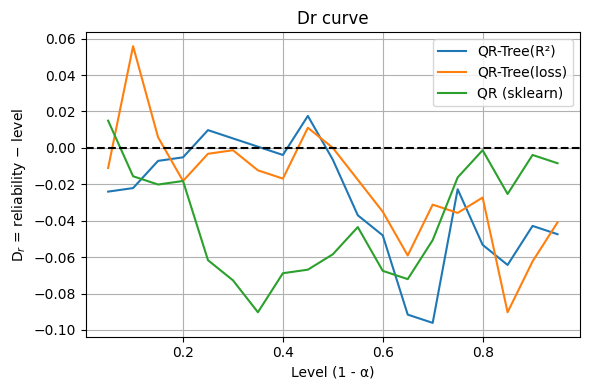

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 定義 levels
levels = np.linspace(0.05, 0.95, 19)

# 2. 蒐集 Dr 值
dr_vals = {name: [] for name in models_interval}
for lvl in levels:
    alpha = 1 - lvl
    lq, uq = alpha / 2, 1 - alpha / 2

    for name, fn in models_interval.items():
        y, low, up = fn(lq, uq)
        rs = reliability_score(y, low, up)
        dr_vals[name].append(dr_metric(rs, alpha))

# 3. 繪圖
plt.figure(figsize=(6, 4))
for name, vals in dr_vals.items():
    plt.plot(levels, vals, label=name)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Level (1 - α)')
plt.ylabel('D$_r$ = reliability − level')
plt.title('Dr curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


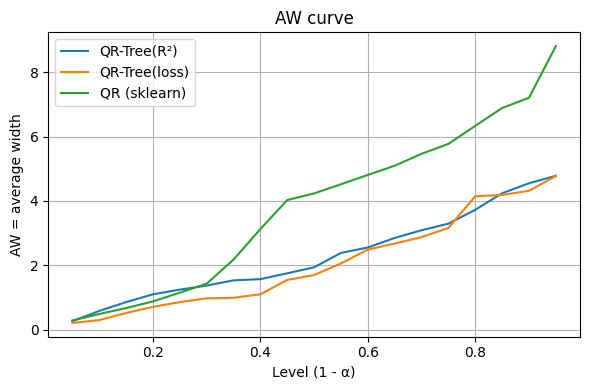

In [8]:
import numpy as np
import matplotlib.pyplot as plt

levels = np.linspace(0.05, 0.95, 19)

aw_vals = {name: [] for name in models_interval}
for lvl in levels:
    alpha = 1 - lvl
    lq, uq = alpha / 2, 1 - alpha / 2

    for name, fn in models_interval.items():
        y, low, up = fn(lq, uq)
        aw_vals[name].append(aw_metric(low, up))

plt.figure(figsize=(6, 4))
for name, vals in aw_vals.items():
    plt.plot(levels, vals, label=name)
plt.xlabel('Level (1 - α)')
plt.ylabel('AW = average width')
plt.title('AW curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


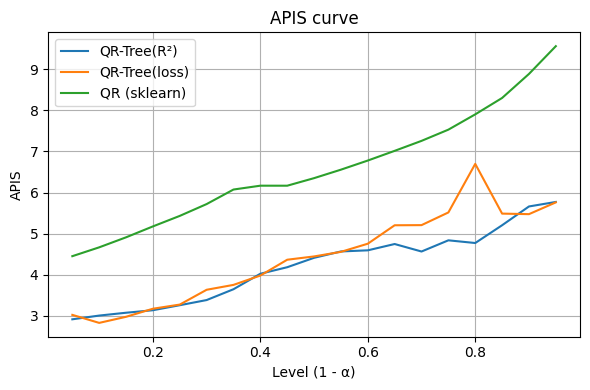

In [9]:
import numpy as np
import matplotlib.pyplot as plt

levels = np.linspace(0.05, 0.95, 19)

apis_vals = {name: [] for name in models_interval}
for lvl in levels:
    alpha = 1 - lvl
    lq, uq = alpha / 2, 1 - alpha / 2

    for name, fn in models_interval.items():
        y, low, up = fn(lq, uq)
        apis_vals[name].append(apis_metric(y, low, up, alpha))

plt.figure(figsize=(6, 4))
for name, vals in apis_vals.items():
    plt.plot(levels, vals, label=name)
plt.xlabel('Level (1 - α)')
plt.ylabel('APIS')
plt.title('APIS curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
models = {
    'QR-Tree(R²)': lambda q: predict_qrt_r2_single(q, max_depth, min_size),
    'QR-Tree(loss)': lambda q: predict_qrt_loss_single(q, max_depth, min_size),
    'QR (sklearn)': lambda q: predict_qrt_single(q)
}

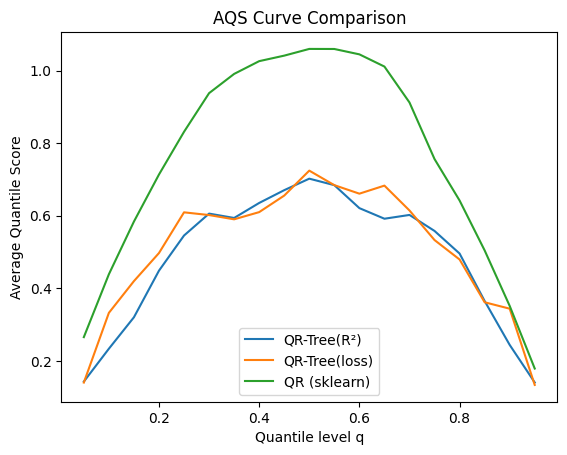

In [11]:
import numpy as np
import matplotlib.pyplot as plt

qs = np.linspace(0.05, 0.95, 19)

#AQS 曲線：對每個模型及 q 計算平均分位損失
aqs_results = {name: [] for name in models}
for q in qs:
    for name, fn in models.items():
        y, pred = fn(q)
        aqs_results[name].append(pinball_loss(y, pred, q))

#繪製 AQS 曲線
plt.figure()
for name, vals in aqs_results.items():
    plt.plot(qs, vals, label=name)
plt.xlabel('Quantile level q')
plt.ylabel('Average Quantile Score')
plt.title('AQS Curve Comparison')
plt.legend()
plt.show()

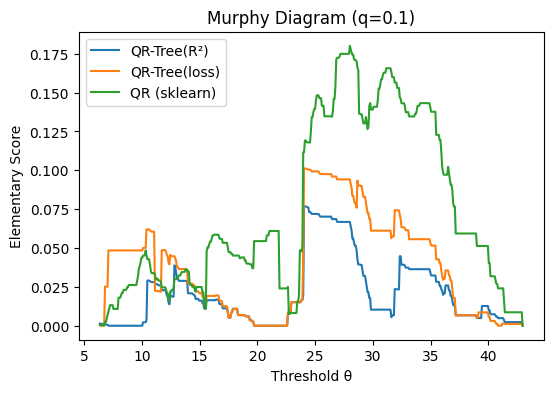

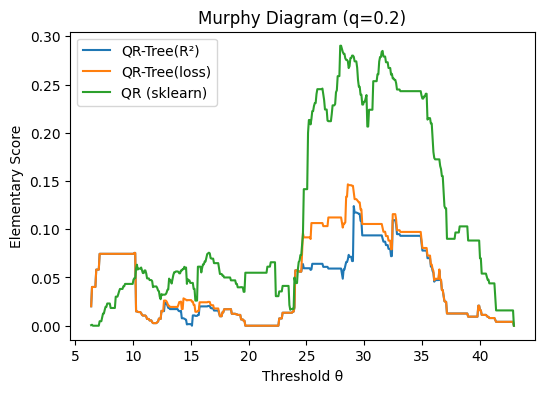

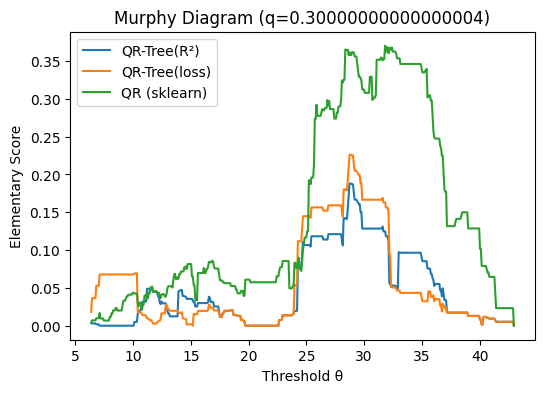

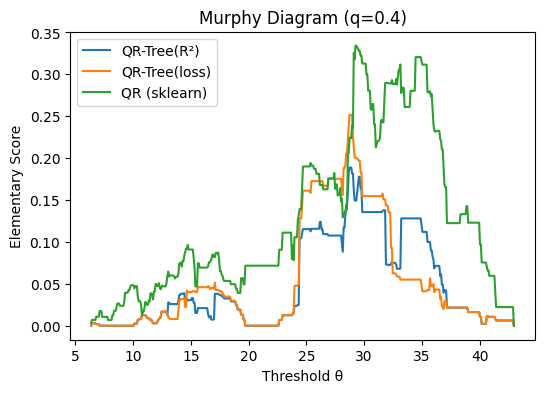

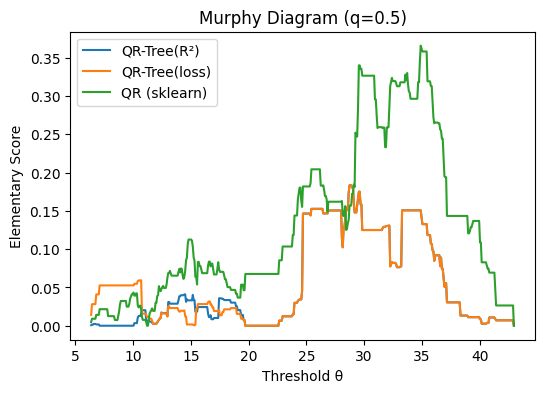

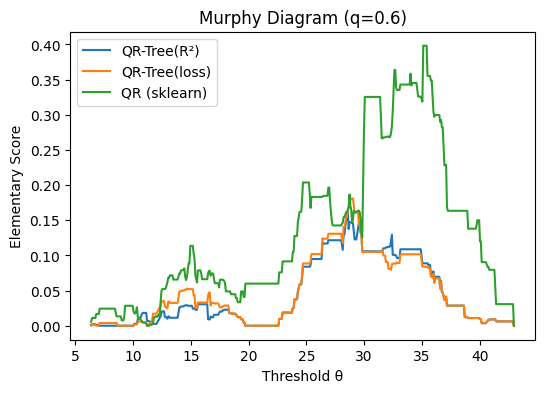

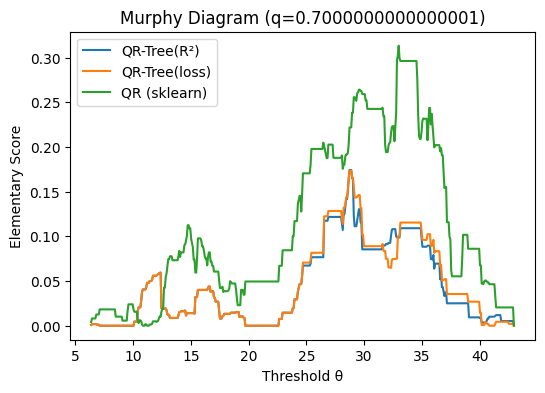

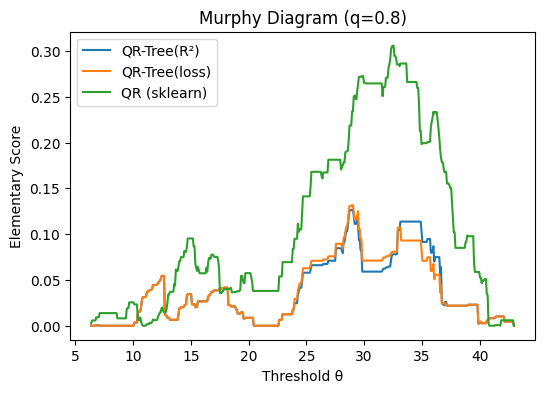

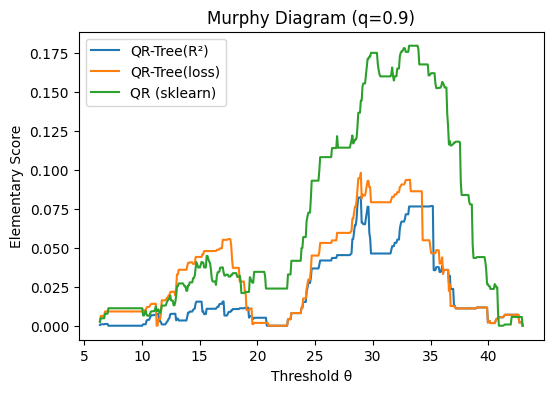

In [12]:
#Murphy diagram：選定單一 q，對每模型畫 elementary score
qs = np.linspace(0.1, 0.9, 9)
thetas = np.linspace(y.min(), y.max(), 500)

for q in qs:
    plt.figure(figsize=(6, 4))
    for name, fn in models.items():
        y_true, y_pred = fn(q)
        abs_err = np.abs(y_true - y_pred)
        scores = []

        for theta in thetas:
            S = np.zeros_like(y_true, dtype=float)

            mask1 = (y_true <= theta) & (theta < y_pred)  # 情况1: y_true ≤ θ < y_pred → S = 1 - τ
            S[mask1] = 1 - q

            mask2 = (y_pred <= theta) & (theta < y_true)  # 情况2: y_pred ≤ θ < y_true → S = τ
            S[mask2] = q

            scores.append(np.mean(S * abs_err))

        plt.plot(thetas, scores, label=name)

    plt.xlabel('Threshold θ')
    plt.ylabel('Elementary Score')
    plt.title(f'Murphy Diagram (q={q})')
    plt.legend()
    plt.show()